## Finding Patterns in Dissents (2007 onwards)

### Question
Are there common patterns in speeches and other features of the economy during dissents / for dissenters?

### Approach

1. Find dissenters from all FOMC meetings after 2007.
2. Find and download speeches made by these dissenters from the Fed website dating between 2 FOMC meetings before their first dissent and upto the FOMC meeting of their last dissent. These will be our considered 'documents'.
3. Run Topic modelling on these speeches together, using LDA (Latent Dirichlet Allocation).
4. Cluster the data based on topics, generate heat maps for topics frequently spoken about (unsupervised learning).
5. Repeat steps 3 and 4, but for speeches of dissenters who wanted tighter, easier and indeterminate action respectively.
5. Train LDA to predict governer action based on speeches made (supervised learning).

We will import the pandas libary to manipulate our datasets.

In [1]:
import pandas as pd

Let's import the dataset for effective Fed Funds Rate, and display the first 5 rows.'

In [2]:
fed_funds = pd.read_csv("datasets/FEDFUNDS.csv")
fed_funds.head()

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.06
3,1954-10-01,0.85
4,1954-11-01,0.83


In [3]:
core_pce = pd.read_csv("datasets/PCEmonthly.csv")
core_pce.columns = list(core_pce.columns[0:1]) + ["EFFECTIVE_FFR"]
core_pce.head()

,DATE,EFFECTIVE_FFR
0,1959-02-01,1.71403
1,1959-03-01,1.81818
2,1959-04-01,-0.13066
3,1959-05-01,1.09027
4,1959-06-01,0.64711


In [4]:
fed_funds_range = pd.read_csv("datasets/FEDFUNDSrange.csv")
fed_funds_range.columns = list(fed_funds_range.columns[0:1]) + ["LOWERBOUND", "UPPERBOUND"]
fed_funds_range.head()

,DATE,LOWERBOUND,UPPERBOUND
0,2008-12-16,0.0,0.25
1,2008-12-17,0.0,0.25
2,2008-12-18,0.0,0.25
3,2008-12-19,0.0,0.25
4,2008-12-20,0.0,0.25


Importing all FOMC dissent data, sourced from publication ["Making Sense of Dissents: A History of FOMC Dissents." Federal Reserve Bank of St. Louis Review, Third Quarter 2014 Vol. 96, No. 3 by authors Daniel L. Thornton and David C. Wheelock](https://www.stlouisfed.org/fomcspeak/history-fomc-dissents).

In [5]:
fomc_dissents = pd.read_csv("datasets/FOMC_Dissents_Data.csv")
fomc_dissents.columns = fomc_dissents.iloc[2]
fomc_dissents
fomc_dissents.drop([0,1,2, 799, 800, 801, 802, 803], axis=0, inplace=True)
fomc_dissents = fomc_dissents.loc[:, fomc_dissents.columns.notnull()]

# filling NaN values
for col in fomc_dissents.columns[9:13]:
    fomc_dissents[col].fillna(0, inplace=True)

fomc_dissents["Year"] = pd.to_numeric(fomc_dissents["Year"]) # converting datatype to numeric
fomc_dissents["FOMC Meeting"] = pd.to_datetime(fomc_dissents["FOMC Meeting"]) # converting datatype to datetime
fomc_dissents.head()

2,Year,FOMC Meeting,Chair,Dissent (Y or N),FOMC Votes,Votes for Action,Votes Against Action,Number Governors Dissenting,Number Presidents Dissenting,No. Governors for Tighter,No. Governors for Easier,No. Presidents for Tighter,No. Presidents for Easier,Dissenters Tighter,Dissenters Easier,Dissenters Other/Indeterminate
3,1936,2036-03-19,Eccles,N,9,9,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1936,2036-05-25,Eccles,N,9,9,0,0,0,0,0,0,0,NaN,NaN,NaN
5,1936,2036-11-20,Eccles,N,11,11,0,0,0,0,0,0,0,NaN,NaN,NaN
6,1937,2037-01-26,Eccles,N,11,11,0,0,0,0,0,0,0,NaN,NaN,NaN
7,1937,2037-03-15,Eccles,N,8,8,0,0,0,0,0,0,0,NaN,NaN,NaN


Filtering for FOMC meetings when dissents took place.

In [6]:
dissenters = fomc_dissents.loc[fomc_dissents["Dissent (Y or N)"] == "Y"]
dissenters.head()

2,Year,FOMC Meeting,Chair,Dissent (Y or N),FOMC Votes,Votes for Action,Votes Against Action,Number Governors Dissenting,Number Presidents Dissenting,No. Governors for Tighter,No. Governors for Easier,No. Presidents for Tighter,No. Presidents for Easier,Dissenters Tighter,Dissenters Easier,Dissenters Other/Indeterminate
18,1938,2038-12-30,Eccles,Y,11,8,3,3,0,0,0,0,0,NaN,NaN,"Eccles, Ransom, Draper"
19,1939,2039-03-07,Eccles,Y,11,8,3,3,0,0,0,0,0,NaN,NaN,"Eccles, Ransom, Draper"
20,1939,2039-03-20,Eccles,Y,11,8,3,3,0,0,0,0,0,NaN,NaN,"Eccles, Ransom, Draper"
21,1939,2039-04-19,Eccles,Y,10,9,1,1,0,0,0,0,0,NaN,NaN,Draper
22,1939,2039-06-21,Eccles,Y,11,10,1,1,0,0,0,0,0,NaN,NaN,Draper


Filtering for meetings only after year 2007.

In [7]:
dissenters_post_2007 = dissenters[dissenters["Year"] > 2007]
dissenters_post_2007

2,Year,FOMC Meeting,Chair,Dissent (Y or N),FOMC Votes,Votes for Action,Votes Against Action,Number Governors Dissenting,Number Presidents Dissenting,No. Governors for Tighter,No. Governors for Easier,No. Presidents for Tighter,No. Presidents for Easier,Dissenters Tighter,Dissenters Easier,Dissenters Other/Indeterminate
710,2008,2008-01-21,Bernanke,Y,9,8,1,0,1,0,0,1,0,Poole,NaN,NaN
711,2008,2008-01-30,Bernanke,Y,10,9,1,0,1,0,0,1,0,Fisher,NaN,NaN
712,2008,2008-03-18,Bernanke,Y,10,8,2,0,2,0,0,2,0,"Fisher, Plosser",NaN,NaN
713,2008,2008-04-30,Bernanke,Y,10,8,2,0,2,0,0,2,0,"Fisher, Plosser",NaN,NaN
714,2008,2008-06-25,Bernanke,Y,10,9,1,0,1,0,0,1,0,Fisher,NaN,NaN
715,2008,2008-08-05,Bernanke,Y,11,10,1,0,1,0,0,1,0,Fisher,NaN,NaN
720,2009,2009-01-28,Bernanke,Y,9,8,1,0,1,0,0,0,0,NaN,NaN,Lacker
728,2010,2010-01-27,Bernanke,Y,10,9,1,0,1,0,0,1,0,Hoenig,NaN,NaN
729,2010,2010-03-16,Bernanke,Y,10,9,1,0,1,0,0,1,0,Hoenig,NaN,NaN
730,2010,2010-04-28,Bernanke,Y,10,9,1,0,1,0,0,1,0,Hoenig,NaN,NaN


In [8]:
# dataframe of dissenters for tighter action
dissenters_tighter = dissenters_post_2007[dissenters_post_2007["Dissenters Tighter"].notnull()]

# finding names of dissenters for tighter action
dissenter_names_tighter = set()
for dissenters in dissenters_tighter["Dissenters Tighter"]:
    diss = dissenters.split(",")
    diss = [d.strip() for d in diss]
    dissenter_names_tighter = dissenter_names_tighter.union(set(diss))

print("Dissenters for tighter action were", dissenter_names_tighter)
dissenters_tighter

Dissenters for tighter action were {'Fisher', 'Poole', 'Mester', 'Lacker', 'Rosengren', 'George', 'Kocherlakota', 'Plosser', 'Hoenig'}


2,Year,FOMC Meeting,Chair,Dissent (Y or N),FOMC Votes,Votes for Action,Votes Against Action,Number Governors Dissenting,Number Presidents Dissenting,No. Governors for Tighter,No. Governors for Easier,No. Presidents for Tighter,No. Presidents for Easier,Dissenters Tighter,Dissenters Easier,Dissenters Other/Indeterminate
710,2008,2008-01-21,Bernanke,Y,9,8,1,0,1,0,0,1,0,Poole,NaN,NaN
711,2008,2008-01-30,Bernanke,Y,10,9,1,0,1,0,0,1,0,Fisher,NaN,NaN
712,2008,2008-03-18,Bernanke,Y,10,8,2,0,2,0,0,2,0,"Fisher, Plosser",NaN,NaN
713,2008,2008-04-30,Bernanke,Y,10,8,2,0,2,0,0,2,0,"Fisher, Plosser",NaN,NaN
714,2008,2008-06-25,Bernanke,Y,10,9,1,0,1,0,0,1,0,Fisher,NaN,NaN
715,2008,2008-08-05,Bernanke,Y,11,10,1,0,1,0,0,1,0,Fisher,NaN,NaN
728,2010,2010-01-27,Bernanke,Y,10,9,1,0,1,0,0,1,0,Hoenig,NaN,NaN
729,2010,2010-03-16,Bernanke,Y,10,9,1,0,1,0,0,1,0,Hoenig,NaN,NaN
730,2010,2010-04-28,Bernanke,Y,10,9,1,0,1,0,0,1,0,Hoenig,NaN,NaN
731,2010,2010-06-23,Bernanke,Y,10,9,1,0,1,0,0,1,0,Hoenig,NaN,NaN


In [9]:
# dataframe of dissenters for easier action
dissenters_easier = dissenters_post_2007[dissenters_post_2007["Dissenters Easier"].notnull()]

# finding names of dissenters for easier action
dissenter_names_easier = set()
for dissenters in dissenters_easier["Dissenters Easier"]:
    diss = dissenters.split(",")
    diss = [d.strip() for d in diss]
    dissenter_names_easier = dissenter_names_easier.union(set(diss))

print("Dissenters for easier action were", dissenter_names_easier)
dissenters_easier

Dissenters for easier action were {'Kocherlakota', 'Kashkari', 'Evans', 'Bullard', 'Rosengren'}


2,Year,FOMC Meeting,Chair,Dissent (Y or N),FOMC Votes,Votes for Action,Votes Against Action,Number Governors Dissenting,Number Presidents Dissenting,No. Governors for Tighter,No. Governors for Easier,No. Presidents for Tighter,No. Presidents for Easier,Dissenters Tighter,Dissenters Easier,Dissenters Other/Indeterminate
742,2011,2011-11-02,Bernanke,Y,10,9,1,0,1,0,0,0,1,NaN,Evans,NaN
743,2011,2011-12-13,Bernanke,Y,10,9,1,0,1,0,0,0,1,NaN,Evans,NaN
755,2013,2013-06-19,Bernanke,Y,12,10,2,0,2,0,0,1,1,George,Bullard,NaN
759,2013,2013-12-18,Bernanke,Y,10,9,1,0,1,0,0,0,1,NaN,Rosengren,NaN
766,2014,2014-10-29,Yellen,Y,10,9,1,0,1,0,0,0,1,NaN,Kocherlakota,NaN
767,2014,2014-12-17,Yellen,Y,10,7,3,0,3,0,0,0,1,NaN,Kocherlakota,"Fisher, Plosser"
785,2017,2017-03-15,Yellen,Y,10,9,1,0,1,0,0,0,1,NaN,Kashkari,NaN
787,2017,2017-06-14,Yellen,Y,9,8,1,0,1,0,0,0,1,NaN,Kashkari,NaN
791,2017,2017-12-13,Yellen,Y,9,7,2,0,2,0,0,0,2,NaN,"Evans, Kashkari",NaN


In [10]:
# dataframe of dissenters for indeterminate action
dissenters_other = dissenters_post_2007[dissenters_post_2007["Dissenters Other/Indeterminate"].notnull()]

# finding names of dissenters for indeterminate action
dissenter_names_other = set()
for dissenters in dissenters_other["Dissenters Other/Indeterminate"]:
    diss = dissenters.split(",")
    diss = [d.strip() for d in diss]
    dissenter_names_other = dissenter_names_other.union(set(diss))

print("Dissenters for indetermnate action were", dissenter_names_other)
dissenters_other

Dissenters for indetermnate action were {'Kocherlakota', 'Fisher', 'Plosser', 'Lacker'}


2,Year,FOMC Meeting,Chair,Dissent (Y or N),FOMC Votes,Votes for Action,Votes Against Action,Number Governors Dissenting,Number Presidents Dissenting,No. Governors for Tighter,No. Governors for Easier,No. Presidents for Tighter,No. Presidents for Easier,Dissenters Tighter,Dissenters Easier,Dissenters Other/Indeterminate
720,2009,2009-01-28,Bernanke,Y,9,8,1,0,1,0,0,0,0,NaN,NaN,Lacker
740,2011,2011-08-09,Bernanke,Y,10,7,3,0,3,0,0,1,0,Kocherlakota,NaN,"Fisher, Plosser"
744,2012,2012-01-25,Bernanke,Y,10,9,1,0,1,0,0,0,0,NaN,NaN,Lacker
745,2012,2012-03-13,Bernanke,Y,10,9,1,0,1,0,0,0,0,NaN,NaN,Lacker
746,2012,2012-04-25,Bernanke,Y,10,9,1,0,1,0,0,0,0,NaN,NaN,Lacker
748,2012,2012-08-01,Bernanke,Y,12,11,1,0,1,0,0,0,0,NaN,NaN,Lacker
761,2014,2014-03-19,Yellen,Y,9,8,1,0,1,0,0,0,0,NaN,NaN,Kocherlakota
764,2014,2014-07-30,Yellen,Y,10,9,1,0,1,0,0,0,0,NaN,NaN,Plosser
765,2014,2014-09-17,Yellen,Y,10,8,2,0,2,0,0,0,0,NaN,NaN,"Fisher, Plosser"
767,2014,2014-12-17,Yellen,Y,10,7,3,0,3,0,0,0,1,NaN,Kocherlakota,"Fisher, Plosser"


In [11]:
print(dissenter_names_other, dissenter_names_tighter, dissenter_names_easier)

{'Kocherlakota', 'Fisher', 'Plosser', 'Lacker'} {'Fisher', 'Poole', 'Mester', 'Lacker', 'Rosengren', 'George', 'Kocherlakota', 'Plosser', 'Hoenig'} {'Kocherlakota', 'Kashkari', 'Evans', 'Bullard', 'Rosengren'}


In [12]:
import os

PATH_TO_SPEECHES = "./datasets/speeches/"
speeches = os.listdir(PATH_TO_SPEECHES)
speeches.sort()
speeches

['2008-01-08_Plosser_The_Economic_Outlook',
 '2008-02-06_Plosser_The_Economic_Outlook',
 '2008-03-03_Plosser_The_Benefits_of_Systemic_Monetary_Policy',
 '2008-03-28_Plosser_Foundations_for_Sound_Central_Banking',
 '2008-04-16_Plosser_Education_and_Economic_Prosperity',
 '2008-04-18_Plosser_Monetary_Policy_and_Financial_Stability',
 '2010-06-03_Hoenig_The_High_Cost_of_Exceptionally_Low_Rates',
 '2010-08-13_Hoenig_Hard_Choices',
 '2010-10-10_Hoenig_Not_Over_till_Over',
 '2010-10-12_Hoenig_Federal_Reserve_Mandate',
 '2010-11-05_Hoenig_Reforming_US_Housing_Finance',
 '2011-08-30_Kocherlakota_Communication_Credibility_Implementation',
 '2011-10-17_Evans_Fed_Dual_Mandate',
 '2011-12-05_Evans_Risk_Management',
 '2012-01-13_Lacker_Economic_Outlook',
 '2012-05-02_Lacker_Economic_Outlook',
 '2012-05-07_Lacker_Technology_Unemployment_Workforce_Development',
 '2012-09-18_Lacker_Maximum_Employment_Monetary_Policy',
 '2012-10-12_Lacker_Challenges_to_Economic_Growth',
 '2012-10-15_Lacker_Economic_Out

Now, importing the text from all the speeches we've gathered and creating a dataframe of the speeches.

In [13]:
documents = pd.DataFrame(columns=["Date", "Author",  "Document"])

for i, speech_filename in enumerate(speeches):
    speech_details = speech_filename.split("_")
    date = speech_details[0]
    author = speech_details[1]
    with open(PATH_TO_SPEECHES + speech_filename) as f:
        documents.loc[i] = [date, author, f.read()]

documents["Date"] = pd.to_datetime(documents["Date"])
documents

,Date,Author,Document
0,2008-01-08,Plosser,Introduction\n\nGood morning and thank you for...
1,2008-02-06,Plosser,Introduction\n\nIt is indeed a pleasure to be ...
2,2008-03-03,Plosser,Introduction\n\nGood morning. I am delighted t...
3,2008-03-28,Plosser,Introduction\n\nLet me thank the Global Interd...
4,2008-04-16,Plosser,Introduction\n\nGood afternoon. It is a pleas...
5,2008-04-18,Plosser,A couple of days ago I thought my role at this...
6,2010-06-03,Hoenig,1 I appreciate the opportunity to join you her...
7,2010-08-13,Hoenig,These are trying times for the U.S. economy. T...
8,2010-10-10,Hoenig,Introduction I was honored to be asked to spea...
9,2010-10-12,Hoenig,"Introduction and Framework Thank you, and it i..."


Dropping fischer's speeches post 2015 since he didn't dissent near those dates.

In [14]:
documents.drop(list(range(44, 50)), axis=0, inplace=True)
documents

,Date,Author,Document
0,2008-01-08,Plosser,Introduction\n\nGood morning and thank you for...
1,2008-02-06,Plosser,Introduction\n\nIt is indeed a pleasure to be ...
2,2008-03-03,Plosser,Introduction\n\nGood morning. I am delighted t...
3,2008-03-28,Plosser,Introduction\n\nLet me thank the Global Interd...
4,2008-04-16,Plosser,Introduction\n\nGood afternoon. It is a pleas...
5,2008-04-18,Plosser,A couple of days ago I thought my role at this...
6,2010-06-03,Hoenig,1 I appreciate the opportunity to join you her...
7,2010-08-13,Hoenig,These are trying times for the U.S. economy. T...
8,2010-10-10,Hoenig,Introduction I was honored to be asked to spea...
9,2010-10-12,Hoenig,"Introduction and Framework Thank you, and it i..."


### Preprocessing the data for LDA (Topic Modelling):

We will follow a tutorial for LDA located here: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

We will perform the following steps:

 - Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
 - Words that have fewer than 3 characters are removed.
 - All stopwords are removed.
 - Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
 - Words are stemmed — words are reduced to their root form.

In [15]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/Pranav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# lots of code repetition but doesn't matter
def tokenize_only(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

# tokenizes and stems
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [17]:
preprocess(documents["Document"][0]) # an example

['introduct',
 'good',
 'morn',
 'thank',
 'invit',
 'help',
 'kick',
 'year',
 'time',
 'year',
 'reflect',
 'prognost',
 'come',
 'economi',
 'import',
 'use',
 'exercis',
 'challeng',
 'task',
 'hand',
 'look',
 'help',
 'understand',
 'happen',
 'hand',
 'tell',
 'happen',
 'economist',
 'adept',
 'offer',
 'multipl',
 'explan',
 'economi',
 'behav',
 'hindsight',
 'term',
 'fact',
 'fuzzier',
 'come',
 'draw',
 'lesson',
 'futur',
 'clariti',
 'materi',
 'year',
 'later',
 'differ',
 'interpret',
 'offer',
 'midst',
 'immedi',
 'aftermath',
 'particular',
 'econom',
 'episod',
 'forecast',
 'futur',
 'cours',
 'difficult',
 'healthi',
 'dose',
 'humil',
 'appropri',
 'nonetheless',
 'forecast',
 'necessari',
 'task',
 'busi',
 'economi',
 'market',
 'product',
 'like',
 'evolv',
 'come',
 'year',
 'critic',
 'action',
 'today',
 'true',
 'policymak',
 'argu',
 'short',
 'morn',
 'want',
 'talk',
 'state',
 'economi',
 'share',
 'view',
 'econom',
 'outlook',
 'comment',
 'uncertai

In [18]:
# creating a vocab dataframe that will be useful later to look up full words by their stem as an index.

# use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for document in documents["Document"]:
    allwords_stemmed = preprocess(document) #for each item in document, tokenize + stem
    totalvocab_stemmed.extend(allwords_stemmed) # extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(document)
    totalvocab_tokenized.extend(allwords_tokenized)
    
print(len(totalvocab_stemmed))
print(len(totalvocab_tokenized))

74110
74110


Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [19]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
vocab_frame.head()

there are 74110 items in vocab_frame


,words
introduct,introduction
good,good
morn,morning
thank,thank
invit,inviting


In [20]:
processed_docs = documents["Document"].map(preprocess)
documents["Processed"] = processed_docs
documents.head()

,Date,Author,Document,Processed
0,2008-01-08,Plosser,Introduction\n\nGood morning and thank you for...,"[introduct, good, morn, thank, invit, help, ki..."
1,2008-02-06,Plosser,Introduction\n\nIt is indeed a pleasure to be ...,"[introduct, pleasur, birmingham, hometown, opp..."
2,2008-03-03,Plosser,Introduction\n\nGood morning. I am delighted t...,"[introduct, good, morn, delight, today, help, ..."
3,2008-03-28,Plosser,Introduction\n\nLet me thank the Global Interd...,"[introduct, thank, global, interdepend, center..."
4,2008-04-16,Plosser,Introduction\n\nGood afternoon. It is a pleas...,"[introduct, good, afternoon, pleasur, montgome..."


Filter out tokens that appear in:

 - less than 15 documents (absolute number) or
 - more than 0.5 documents (fraction of total corpus size, not absolute number).
 - after the above two steps, keep only the first 100000 most frequent tokens.

In [21]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print(dictionary)

Dictionary(337 unique tokens: ['introduct', 'morn', 'invit', 'use', 'hand']...)


Now, we're creating a bag of words for each document. Meaning, for each document, what were the word frequencies for each token in our dictionary? The key is the word index in the dictionary, the value is the number of times it appeared. If the key doesn't exist, the token didn't appear.

In [22]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
len(bow_corpus) # number of documents (speeches)
bow_corpus[0] # example - bag of words for the 0th speech

[(0, 2),
 (1, 2),
 (2, 1),
 (3, 1),
 (4, 4),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 5),
 (11, 1),
 (12, 4),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 3),
 (17, 7),
 (18, 2),
 (19, 1),
 (20, 2),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 4),
 (26, 4),
 (27, 1),
 (28, 7),
 (29, 1),
 (30, 3),
 (31, 2),
 (32, 1),
 (33, 2),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 4),
 (40, 1),
 (41, 4),
 (42, 1),
 (43, 8),
 (44, 2),
 (45, 3),
 (46, 2),
 (47, 2),
 (48, 1),
 (49, 3),
 (50, 5),
 (51, 3),
 (52, 2),
 (53, 2),
 (54, 1),
 (55, 2),
 (56, 1),
 (57, 2),
 (58, 2),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 2),
 (63, 2),
 (64, 3),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 2),
 (74, 1),
 (75, 3),
 (76, 1),
 (77, 2),
 (78, 2),
 (79, 2),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 3),
 (85, 3),
 (86, 1),
 (87, 1),
 (88, 5),
 (89, 1),
 (90, 2),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 4),
 (98, 1),
 (99, 1),
 (100, 1),

### TF-IDF

http://www.tfidf.com/

TF stands for "term frequency" and IDF forms for "Inverse Document Frequency". The formula is used to weight the importance of words in a corpus, and this is what we're going to do now. The formulae are in the link above.

The formula for the metric accounts for the fact that some terms may be more frequent across documents in general, like "of" for example and normalizes the weight accordingly.

In [23]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus] # transforms the word-document co-occurence matrix into word-document tf-idf matrix.

from pprint import pprint

for doc in corpus_tfidf: # printing the tf-idf score for tokens in first document.
    pprint(doc)
    break

[(0, 0.07265991627709271),
 (1, 0.10430984754639354),
 (2, 0.04238750872172476),
 (3, 0.031047974758494374),
 (4, 0.1784861103664731),
 (5, 0.04238750872172476),
 (6, 0.058854805947316104),
 (7, 0.05215492377319677),
 (8, 0.044621527591618276),
 (9, 0.044621527591618276),
 (10, 0.26077461886598385),
 (11, 0.046983272325147395),
 (12, 0.16107242609779798),
 (13, 0.05215492377319677),
 (14, 0.044621527591618276),
 (15, 0.031047974758494374),
 (16, 0.11475639562651699),
 (17, 0.2543097069698245),
 (18, 0.08477501744344952),
 (19, 0.044621527591618276),
 (20, 0.09897647658080926),
 (21, 0.04948823829040463),
 (22, 0.040268106524449496),
 (23, 0.04948823829040463),
 (24, 0.046983272325147395),
 (25, 0.11770961189463221),
 (26, 0.130938841371484),
 (27, 0.046983272325147395),
 (28, 0.36508446641237735),
 (29, 0.05215492377319677),
 (30, 0.12080431957334849),
 (31, 0.06898648627458347),
 (32, 0.044621527591618276),
 (33, 0.058854805947316104),
 (34, 0.04238750872172476),
 (35, 0.0310479747584

## Training the LDA model

In [34]:
NUM_TOPICS = 20

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=2, workers=2)

In [35]:
for idx, topic in lda_model.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.015*"credibl" + 0.011*"revis" + 0.011*"mandat" + 0.009*"weak" + 0.009*"global" + 0.009*"core" + 0.008*"januari" + 0.008*"output" + 0.007*"august" + 0.007*"rule"

Topic: 1 
Words: 0.020*"global" + 0.019*"mandat" + 0.014*"core" + 0.010*"industri" + 0.010*"weak" + 0.010*"dual" + 0.010*"leverag" + 0.010*"liquid" + 0.010*"trillion" + 0.009*"negat"

Topic: 2 
Words: 0.029*"global" + 0.018*"credibl" + 0.016*"tighten" + 0.015*"expans" + 0.015*"domest" + 0.012*"expand" + 0.012*"mandat" + 0.012*"output" + 0.011*"weak" + 0.011*"dollar"

Topic: 3 
Words: 0.089*"rule" + 0.027*"model" + 0.021*"ratio" + 0.017*"leverag" + 0.015*"regul" + 0.011*"communic" + 0.010*"optim" + 0.010*"practic" + 0.009*"behavior" + 0.009*"lend"

Topic: 4 
Words: 0.031*"control" + 0.026*"banker" + 0.021*"citi" + 0.018*"propos" + 0.018*"hand" + 0.017*"congress" + 0.017*"presid" + 0.017*"centuri" + 0.016*"establish" + 0.016*"interest"

Topic: 5 
Words: 0.057*"rule" + 0.043*"communic" + 0.038*"model" + 0.029*

So now, we have a trained model that can classify a document into the topic for which the LDA model outputs the highest probability based on the probability that results above.

I chose 65 topics based off similar analysis of the scope of Fed speeches in CIGI Papers No. 202 — November 2018 • Pierre L. Siklos, Samantha St. Amand and Joanna Wajda. (NOOOOOO too many topics)

Chose 20 topics instead.

In [36]:
# shows topics and the 10 most relevant words for each
topics = lda_model.show_topics(num_topics=NUM_TOPICS, formatted=False)
topics

[(0,
  [('credibl', 0.014798314818573388),
   ('revis', 0.011425097320490726),
   ('mandat', 0.010525389261349587),
   ('weak', 0.0092710500702048622),
   ('global', 0.0087651659924084056),
   ('core', 0.008610275340751752),
   ('januari', 0.0084156315166278983),
   ('output', 0.008294308589602218),
   ('august', 0.007293045966876183),
   ('rule', 0.0072528988404414775)]),
 (1,
  [('global', 0.019891696158838939),
   ('mandat', 0.018733285947149146),
   ('core', 0.013818215616624132),
   ('industri', 0.010440120773182649),
   ('weak', 0.010275616910261057),
   ('dual', 0.010204799759267495),
   ('leverag', 0.010145959743167123),
   ('liquid', 0.0095726183639948965),
   ('trillion', 0.0095230817683569554),
   ('negat', 0.009181658599994107)]),
 (2,
  [('global', 0.028599486880363421),
   ('credibl', 0.01843005686456221),
   ('tighten', 0.015751636728447364),
   ('expans', 0.015093041719541121),
   ('domest', 0.01483601126384137),
   ('expand', 0.012118795899365127),
   ('mandat', 0.0120

In [37]:
labels = [[] for x in range(len(topics))]
probabilities = [[] for x in range(len(topics))]

for idx, topic in enumerate(topics):
    for tup in topic[1]:
        word, prob = tup
        labels[idx].append(word)
        probabilities[idx].append(prob)

labels = np.asarray(labels)
probabilities = np.asarray(probabilities)

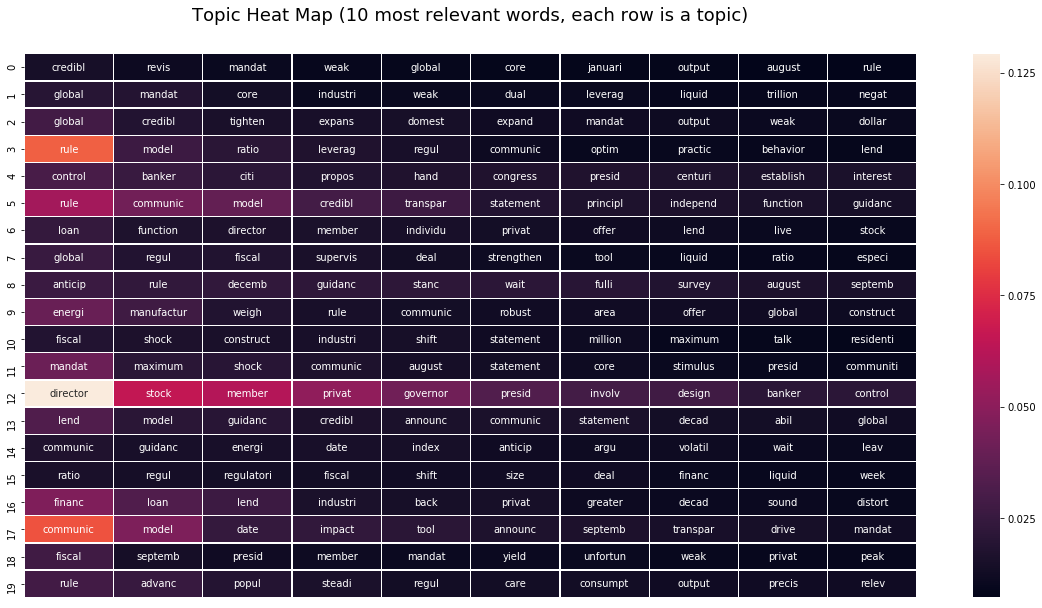

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
title = "Topic Heat Map (10 most relevant words, each row is a topic)"
plt.title(title, fontsize=18)

ttl = ax.title
ttl.set_position([0.5, 1.05])

# hide ticks for x and y axis
ax.set_xticks([])
# ax.set_yticks([])

# remove axis
# ax.axis("off")

sns.heatmap(probabilities, annot=labels, fmt="", ax=ax, linewidth=0.3, xticklabels=False)
plt.show()

There seem to be a lot of common words between all the rows (topics), which gives us a sense that perhaps, we've picked too large a number for the topics. We should run the same analysis later and try reducing the number.

## Document Clustering to find latent structures between speeches made by dissenters around the time of dissent

 - I will be following [this](http://brandonrose.org/clustering#Tf-idf-and-document-similarity) tutorial to do the cluster analysis.
 - We will do K-Means clustering and ward clustering as well.
 
Parameters:

 - max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
 - min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
 - ngram_range: this just means I'll look at unigrams, bigrams and trigrams. An n-gram is a contiguous sequence of n items from a given sample of text or speech.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=preprocess, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(documents["Document"]) #fit the vectorizer to synopses

# list of all the n-grams considered
terms = tfidf_vectorizer.get_feature_names()

print(tfidf_matrix.shape) # 53 documents, 922 terms
print(terms) # 922 of them

(53, 922)
['abil', 'abl', 'acceler', 'accept', 'access', 'accommod', 'accommod monetari', 'accommod monetari polici', 'accord', 'account', 'achiev', 'achiev goal', 'acknowledg', 'actual', 'add', 'address', 'adjust', 'adopt', 'advanc', 'advers', 'affect', 'afford', 'aftermath', 'agenc', 'aggreg', 'aggress', 'agre', 'ahead', 'align', 'alloc', 'allow', 'alter', 'altern', 'american', 'analysi', 'announc', 'annual', 'annual rate', 'answer', 'anticip', 'appar', 'appear', 'appli', 'appreci', 'approach', 'appropri', 'area', 'argu', 'aris', 'aspect', 'assess', 'asset', 'asset price', 'asset purchas', 'asset purchas program', 'associ', 'assum', 'attempt', 'attent', 'attribut', 'august', 'author', 'auto', 'avail', 'averag', 'averag percent', 'avoid', 'awar', 'away', 'balanc', 'balanc sheet', 'banker', 'base', 'basi', 'basi point', 'bear', 'behav', 'behavior', 'believ', 'benchmark', 'benefit', 'best', 'better', 'billion', 'bind', 'board', 'board director', 'board governor', 'board governor feder',

dist is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more synopses.

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)

Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the documents. I first chose k-means. K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima.


In [42]:
from sklearn.cluster import KMeans

num_clusters = 10 # can change - to correspond to topic modelling above with LDA, ideally should be 65?

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [43]:
# assigning each document the centroid it got allocated to during k means

clustered_frame = documents.copy()
clustered_frame["cluster"] = clusters
clustered_frame.set_index("cluster", inplace=True)
clustered_frame.index.value_counts() # shows number of documents that got assigned to that particular cluster

8    10
1     9
3     7
7     5
2     5
9     4
5     4
4     4
0     3
6     2
Name: cluster, dtype: int64

Here is some fancy indexing and sorting on each cluster to identify which are the top n (I chose n=10) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster.

In [60]:
from __future__ import print_function
from datetime import datetime

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
# print(order_centroids)

print("\nTop terms per cluster: \n")

for i in range(num_clusters):
    print("Cluster %d words:\n\t" % i, end='')
    
    for ind in order_centroids[i, :10]: # replace 10 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    
    print("\nCluster %d dates:\n\t" % i, end='')
    for date in clustered_frame.ix[i]['Date']:
        print(date, end=', ')
    
    print("\nCluster %d Authors:\n\t" % i, end='')
    for author in clustered_frame.ix[i]['Author'].values.tolist():
        print(' %s,' % author, end='')
    
    print('\n\n')


Top terms per cluster: 

Cluster 0 words:
	 b'mandate', b'maximum', b'shocks', b'maximum', b'statement', b'objective', b'communication', b'unemployment', b'prices', b'slack',
Cluster 0 dates:
	2011-08-30 00:00:00, 2012-09-18 00:00:00, 2014-11-05 00:00:00, 
Cluster 0 Authors:
	 Kocherlakota, Lacker, Kocherlakota,


Cluster 1 words:
	 b'capital', b'crisis', b'global', b'united', b'united', b'housing', b'commercial', b'ratio', b'institution', b'largest',
Cluster 1 dates:
	2010-08-13 00:00:00, 2010-10-10 00:00:00, 2010-11-05 00:00:00, 2013-10-16 00:00:00, 2013-11-18 00:00:00, 2014-07-10 00:00:00, 2014-08-11 00:00:00, 2014-10-11 00:00:00, 2016-08-31 00:00:00, 
Cluster 1 Authors:
	 Hoenig, Hoenig, Hoenig, George, Rosengren, Fischer, Fischer, Fischer, Rosengren,


Cluster 2 words:
	 b'quarter', b'rules', b'october', b'labor', b'funds', b'nearly', b'zero', b'longer', b'assess', b'monthly',
Cluster 2 dates:
	2014-09-06 00:00:00, 2014-10-16 00:00:00, 2014-11-12 00:00:00, 2014-11-13 00:00:00, 20

In [49]:
for date in clustered_frame.ix[9]['Date']:
    print(date)

2008-01-08 00:00:00
2008-02-06 00:00:00
2008-04-18 00:00:00
2016-02-02 00:00:00
